## POS tagging using modified Viterbi

### Problem Statement:

The vanilla Viterbi algorithm we had written had resulted in ~87% accuracy. The approx. 13% loss of accuracy was majorly due to the fact that when the algorithm encountered an unknown word (i.e. not present in the training set, such as 'Twitter'), it assigned an incorrect tag arbitrarily. This is because, for unknown words, the emission probabilities for all candidate tags are 0, so the algorithm arbitrarily chooses (the first) tag.

In this assignment, I have modified the Viterbi algorithm to solve the problem of unknown words using two techniques:
    1. By looking into traning set, 'NOUN' is the most common tag. I have tagged  the words which are not in training set with 'NOUN'. Which leads in increase in accuracy from 91% to 94.1%.
    2. Second approch I have used to guess the current tag from the previous tag. For ex. if 'NOUN' is the previous tag then in the corpus we could see next most likely tag is 'NOUN' or if 'Adverb' is the previous tag them most likely currnt tag is 'Verb' and so on. So I have selected the most likely next tag based on previous tag and got accuracy as 94.3%.

### Data Preparation

In [39]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [40]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [41]:
#printing first few tagged sentences
print(nltk_data[:20])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [51]:
# Splitting into train and test in the ration of 95:5
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:10])

3718
196
[[('Mr.', 'NOUN'), ('Stearn', 'NOUN'), (',', '.'), ('46', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('could', 'VERB'), ("n't", 'ADV'), ('be', 'VERB'), ('reached', 'VERB'), ('*-120', 'X'), ('for', 'ADP'), ('comment', 'NOUN'), ('.', '.')], [('``', '.'), ('Just', 'ADV'), ('as', 'ADP'), ('the', 'DET'), ('1980s', 'NUM'), ('bull', 'NOUN'), ('market', 'NOUN'), ('transformed', 'VERB'), ('the', 'DET'), ('U.S.', 'NOUN'), ('securities', 'NOUN'), ('business', 'NOUN'), (',', '.'), ('so', 'ADV'), ('too', 'ADV'), ('will', 'VERB'), ('*?*', 'X'), ('the', 'DET'), ('more', 'ADV'), ('difficult', 'ADJ'), ('environment', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('1990s', 'NUM'), (',', '.'), ("''", '.'), ('says', 'VERB'), ('*T*-1', 'X'), ('Christopher', 'NOUN'), ('T.', 'NOUN'), ('Mahoney', 'NOUN'), (',', '.'), ('a', 'DET'), ('Moody', 'NOUN'), ("'s", 'PRT'), ('vice', 'NOUN'), ('president', 'NOUN'), ('.', '.')], [('``', '.'), ('There', 'DET'), ('may', 'VERB'), ('be', 'VERB'), ('sticker-sho

Training dataset is having 3718 sentences and Test dataset is having 196 sentences.

In [52]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95749

In [53]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Mr.', 'Stearn', ',', '46', 'years', 'old', ',', 'could', "n't", 'be']

In [54]:
# tags
tags = [pair[1] for pair in train_tagged_words]

In [55]:
# vocabulary
V = set(tokens)
print(len(V))

12072


Length of vocabulary is 12055.

In [56]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [57]:
# Printing the tags
print(T)

{'PRT', 'VERB', 'CONJ', 'PRON', 'ADV', 'X', 'DET', 'NUM', '.', 'ADJ', 'ADP', 'NOUN'}


In [58]:
# Frequency of the tags

from collections import Counter
tag_counts = Counter(tags)
tag_counts

Counter({'NOUN': 27478,
         '.': 11144,
         'NUM': 3364,
         'ADJ': 6085,
         'VERB': 12886,
         'ADV': 3025,
         'X': 6266,
         'ADP': 9382,
         'DET': 8281,
         'PRT': 3060,
         'CONJ': 2158,
         'PRON': 2620})

In [59]:
# Most common tags
tag_counts.most_common(5)

[('NOUN', 27478), ('VERB', 12886), ('.', 11144), ('ADP', 9382), ('DET', 8281)]

Above are the 5 most common tags in the corpus.

### POS Tagging Algorithm - HMM

To tag a given word, we will be required emmission and the transition probabilities. 
 
    State_probability = emmission probability * transition probability
    
And, the tag which gives us the maximum of state_probability will be the tag for the word

### Emission Probabilities 

In [60]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [61]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [62]:
# Examples
# would
print("\n", "would")
print(word_given_tag('would', 'VERB'))
print(word_given_tag('would', 'NOUN'))

# flights 
print("\n", "flights")
print(word_given_tag('flights', 'NOUN'))
print(word_given_tag('flights', 'PRON'))
print(word_given_tag('flights', 'VERB'))

# Android
print("\n", "Android")
print(word_given_tag('Android', 'NOUN'))
print(word_given_tag('Android', 'PRON'))


 would
(198, 12886)
(0, 27478)

 flights
(2, 27478)
(0, 2620)
(0, 12886)

 Android
(0, 27478)
(0, 2620)


### Transition Probabilities

In [63]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [64]:
# examples
print(t2_given_t1(t2='NOUN', t1='ADJ'))
print(t2_given_t1('NOUN', 'PRT'))
print(t2_given_t1('NOUN', 'DET'))

(4250, 6085)
(768, 3060)
(5300, 8281)


In [65]:
# P(tag|start) Or P(tag|'.')
print(t2_given_t1('DET', '.'))
print(t2_given_t1('VERB', '.'))

(1924, 11144)
(989, 11144)


In [66]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [67]:
tags_matrix

array([[1.96078443e-03, 3.97712409e-01, 2.28758180e-03, 1.73202623e-02,
        1.01307193e-02, 1.30718956e-02, 1.00000001e-01, 5.65359481e-02,
        4.44444455e-02, 8.62745121e-02, 1.92810465e-02, 2.50980407e-01],
       [3.09638362e-02, 1.68943033e-01, 5.35464846e-03, 3.58528644e-02,
        8.24150220e-02, 2.16514051e-01, 1.34564638e-01, 2.31258739e-02,
        3.49216200e-02, 6.56526461e-02, 9.14170444e-02, 1.10274717e-01],
       [5.09731239e-03, 1.55699715e-01, 4.63392033e-04, 5.79240024e-02,
        5.51436506e-02, 7.87766464e-03, 1.20945320e-01, 4.17052843e-02,
        3.47544029e-02, 1.18164964e-01, 5.32900840e-02, 3.48934203e-01],
       [1.22137405e-02, 4.85114515e-01, 4.58015269e-03, 8.01526755e-03,
        3.32061052e-02, 9.23664123e-02, 9.92366392e-03, 7.25190854e-03,
        4.12213728e-02, 7.29007646e-02, 2.25190837e-02, 2.10687026e-01],
       [1.32231405e-02, 3.45123976e-01, 6.94214879e-03, 1.55371903e-02,
        8.09917375e-02, 2.31404956e-02, 6.94214851e-02, 3.17

In [68]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [69]:
tags_df

,PRT,VERB,CONJ,PRON,ADV,X,DET,NUM,.,ADJ,ADP,NOUN
PRT,0.001961,0.397712,0.002288,0.017320,0.010131,0.013072,0.100000,0.056536,0.044444,0.086275,0.019281,0.250980
VERB,0.030964,0.168943,0.005355,0.035853,0.082415,0.216514,0.134565,0.023126,0.034922,0.065653,0.091417,0.110275
CONJ,0.005097,0.155700,0.000463,0.057924,0.055144,0.007878,0.120945,0.041705,0.034754,0.118165,0.053290,0.348934
PRON,0.012214,0.485115,0.004580,0.008015,0.033206,0.092366,0.009924,0.007252,0.041221,0.072901,0.022519,0.210687
ADV,0.013223,0.345124,0.006942,0.015537,0.080992,0.023140,0.069421,0.031736,0.135207,0.128264,0.119669,0.030744
X,0.184009,0.205235,0.010054,0.055538,0.025854,0.074050,0.053782,0.002873,0.165018,0.016757,0.144909,0.061921
DET,0.000242,0.039005,0.000362,0.003502,0.012921,0.046009,0.005193,0.022461,0.016906,0.203961,0.009419,0.640019
NUM,0.027051,0.019025,0.013971,0.001486,0.002973,0.210761,0.003270,0.185493,0.116528,0.033888,0.033888,0.351665
.,0.002423,0.088747,0.058776,0.066134,0.052136,0.027728,0.172649,0.080402,0.093324,0.044777,0.091350,0.221464
ADJ,0.010846,0.011832,0.016927,0.000493,0.004437,0.021200,0.005094,0.020542,0.065407,0.066228,0.078554,0.698439


In [70]:
tags_df.loc['.', :]

PRT     0.002423
VERB    0.088747
CONJ    0.058776
PRON    0.066134
ADV     0.052136
X       0.027728
DET     0.172649
NUM     0.080402
.       0.093324
ADJ     0.044777
ADP     0.091350
NOUN    0.221464
Name: ., dtype: float32

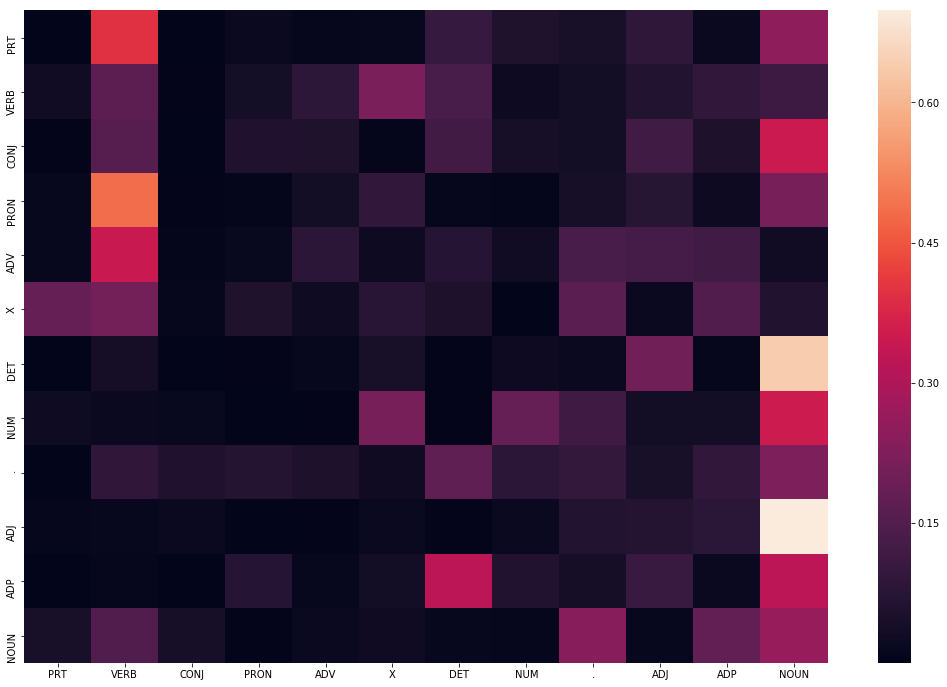

In [71]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

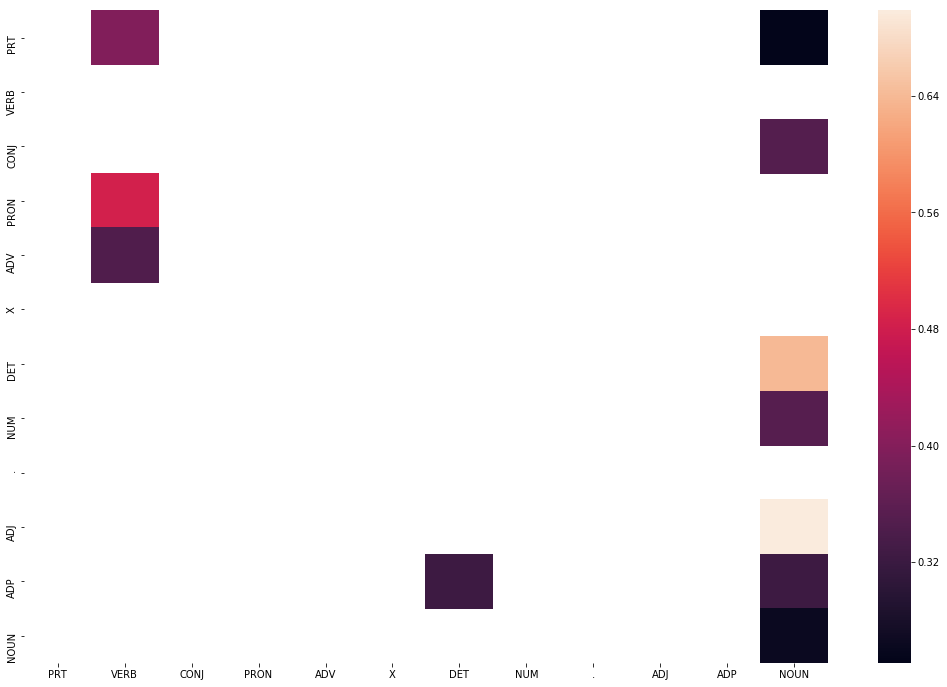

In [73]:
# frequent tags
# filter the df to get P(t2, t1) > 0.25
tags_frequent = tags_df[tags_df>0.25]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

Clearly from the above figure we could see that NOUN is the most likely POS tag that follows DET or PRT or NOUN.

### Viterbi Algorithm

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.

Note: P(tag|start) = P(tag|'.')

### Unmodified Viterbi Heuristic POS tagger

In [74]:
# Unmodified Viterbi Heuristic POS tagger
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

### Evaluating on the Validation set

In [75]:
# Let's test our Viterbi algorithm on test dataset

# list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
test_set[:10]

[[('Few', 'ADJ'),
  ('people', 'NOUN'),
  ('think', 'VERB'),
  ('0', 'X'),
  ('Mr.', 'NOUN'),
  ('Spiegel', 'NOUN'),
  ('wants', 'VERB'),
  ('*-1', 'X'),
  ('to', 'PRT'),
  ('run', 'VERB'),
  ('a', 'DET'),
  ('bread-and-butter', 'ADJ'),
  ('thrift', 'NOUN'),
  (',', '.'),
  ('which', 'DET'),
  ('current', 'ADJ'),
  ('rules', 'NOUN'),
  ('would', 'VERB'),
  ('force', 'VERB'),
  ('Columbia', 'NOUN'),
  ('to', 'PRT'),
  ('become', 'VERB'),
  ('*T*-2', 'X'),
  ('.', '.')],
 [('Too', 'ADV'),
  ('often', 'ADV'),
  ('now', 'ADV'),
  (',', '.'),
  ('a', 'DET'),
  ('single', 'ADJ'),
  ('court', 'NOUN'),
  ('decision', 'NOUN'),
  ('becomes', 'VERB'),
  ('the', 'DET'),
  ('precedent', 'NOUN'),
  ('for', 'ADP'),
  ('other', 'ADJ'),
  (',', '.'),
  ('less', 'ADV'),
  ('compelling', 'ADJ'),
  ('cases', 'NOUN'),
  ('.', '.')],
 [('The', 'DET'), ('next', 'ADJ'), ('province', 'NOUN'), ('?', '.')],
 [('After', 'ADP'),
  ('the', 'DET'),
  ('race', 'NOUN'),
  (',', '.'),
  ('Fortune', 'NOUN'),
  ('500', '

In [76]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [112]:
print("Time taken in seconds: ", difference)
print('Tagged_Seq:\n')
print(tagged_seq)
print('\n')
print('test_run_base:\n')
print(test_run_base)

Time taken in seconds:  37.288819551467896
Tagged_Seq:

[('Few', 'ADJ'), ('people', 'NOUN'), ('think', 'VERB'), ('0', 'X'), ('Mr.', 'NOUN'), ('Spiegel', 'NOUN'), ('wants', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('run', 'VERB'), ('a', 'DET'), ('bread-and-butter', 'NOUN'), ('thrift', 'NOUN'), (',', '.'), ('which', 'DET'), ('current', 'ADJ'), ('rules', 'NOUN'), ('would', 'VERB'), ('force', 'VERB'), ('Columbia', 'NOUN'), ('to', 'PRT'), ('become', 'VERB'), ('*T*-2', 'X'), ('.', '.'), ('Too', 'ADV'), ('often', 'ADV'), ('now', 'ADV'), (',', '.'), ('a', 'DET'), ('single', 'ADJ'), ('court', 'NOUN'), ('decision', 'NOUN'), ('becomes', 'VERB'), ('the', 'DET'), ('precedent', 'NOUN'), ('for', 'ADP'), ('other', 'ADJ'), (',', '.'), ('less', 'ADJ'), ('compelling', 'NOUN'), ('cases', 'NOUN'), ('.', '.'), ('The', 'DET'), ('next', 'ADJ'), ('province', 'NOUN'), ('?', '.'), ('After', 'ADP'), ('the', 'DET'), ('race', 'NOUN'), (',', '.'), ('Fortune', 'NOUN'), ('500', 'NUM'), ('executives', 'NOUN'), ('drooled',

In [78]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 

In [79]:
accuracy = len(check)/len(tagged_seq)

In [80]:
accuracy

0.9029835599756444

We could see accuracy is ~90%, approx 10% loss in accuracy is due to unknown words.

In [81]:
# Incorrect tagged words
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [82]:
incorrect_tagged_cases

[[('a', 'DET'), (('bread-and-butter', 'PRT'), ('bread-and-butter', 'ADJ'))],
 [(',', '.'), (('less', 'ADJ'), ('less', 'ADV'))],
 [('less', 'ADV'), (('compelling', 'PRT'), ('compelling', 'ADJ'))],
 [('next', 'ADJ'), (('province', 'PRT'), ('province', 'NOUN'))],
 [(',', '.'), (('Fortune', 'PRT'), ('Fortune', 'NOUN'))],
 [('executives', 'NOUN'), (('drooled', 'PRT'), ('drooled', 'VERB'))],
 [('drooled', 'VERB'), (('like', 'VERB'), ('like', 'ADP'))],
 [('like', 'ADP'), (('schoolboys', 'PRT'), ('schoolboys', 'NOUN'))],
 [('the', 'DET'), (('autions', 'PRT'), ('autions', 'NOUN'))],
 [('be', 'VERB'), (('rescheduled', 'PRT'), ('rescheduled', 'VERB'))],
 [('rescheduled', 'VERB'), (('*-106', 'PRT'), ('*-106', 'X'))],
 [('*-1', 'X'), (('Encouraged', 'PRT'), ('Encouraged', 'ADJ'))],
 [('taught', 'VERB'), (('honor', 'VERB'), ('honor', 'NOUN'))],
 [('a', 'DET'), (('low-tech', 'PRT'), ('low-tech', 'ADJ'))],
 [('like', 'ADP'), (('plate', 'PRT'), ('plate', 'NOUN'))],
 [('can', 'VERB'), (('catch', 'NOUN')

Unkown words are moslty tagged with 'PRT' POS, since 'PRT' is the first POS. Like  the words province, schoolboys, plate are tagged with 'PRT' POS.

### POS Tagging on the test set Using original Viterbi Algorithm

In [149]:
## Testing
#Reading the text file provided in the given assignment.

with open('Test_sentences.txt') as f:
    sentence_test  = f.read()

words = word_tokenize(sentence_test)
start = time.time()
tagged_seq01 = Viterbi(words)
end = time.time()
difference = end-start

In [150]:
print(tagged_seq01)
print(difference)

[('Android', 'PRT'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'PRT'), ('.', '.'), ('Android', 'PRT'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'PRT'), ('worldwide', 'PRT'), ('on', 'ADP'), ('smartphones', 'PRT'), ('since', 'ADP'), ('2011', 'PRT'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'PRT'), ('.', '.'), ('Google', 'PRT'), ('and', 'CONJ'), ('Twitter', 'PRT'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'PRT'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'PRT'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'PRT'), ("'s", 'VERB'), ('firehose', 'PRT'), ('.', '.'), ('Twitter', 'PRT'), ('is', 'VERB'), ('an', 'DET'), ('online', 'PRT'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NO

Here, we could see most of the unknown words like Android, Google, Twitter etc are tagged with "PRT", since this is the first tag.

### Solving the problem of unknown words

#### Approach 1: Modified Viterbi Heuristic algorithm. Since most commonn tag in the corpus is NOUN,  Tagging the words which are not in the corpus with most common tag i.e 'NOUN'

In [85]:
# Approach 1: Modified Viterbi Heuristic algorithm. Since most commonn tag in the corpus is NOUN,  
# Tagging the words which are not in the corpus with most common tag i.e 'NOUN'

def Viterbi_1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        if pmax == 0:
            state.append('NOUN')
        else: 
            state_max = T[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

#### POS Tagging on the Validation dataset

In [91]:
# tagging the test sentences
start = time.time()
tagged_seq1 = Viterbi_1(test_tagged_words)
end = time.time()
difference = end-start

In [92]:
print("Time taken in seconds: ", difference)
print(tagged_seq1)

Time taken in seconds:  965.7043826580048
[('Few', 'ADJ'), ('people', 'NOUN'), ('think', 'VERB'), ('0', 'X'), ('Mr.', 'NOUN'), ('Spiegel', 'NOUN'), ('wants', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('run', 'VERB'), ('a', 'DET'), ('bread-and-butter', 'NOUN'), ('thrift', 'NOUN'), (',', '.'), ('which', 'DET'), ('current', 'ADJ'), ('rules', 'NOUN'), ('would', 'VERB'), ('force', 'VERB'), ('Columbia', 'NOUN'), ('to', 'PRT'), ('become', 'VERB'), ('*T*-2', 'X'), ('.', '.'), ('Too', 'ADV'), ('often', 'ADV'), ('now', 'ADV'), (',', '.'), ('a', 'DET'), ('single', 'ADJ'), ('court', 'NOUN'), ('decision', 'NOUN'), ('becomes', 'VERB'), ('the', 'DET'), ('precedent', 'NOUN'), ('for', 'ADP'), ('other', 'ADJ'), (',', '.'), ('less', 'ADJ'), ('compelling', 'NOUN'), ('cases', 'NOUN'), ('.', '.'), ('The', 'DET'), ('next', 'ADJ'), ('province', 'NOUN'), ('?', '.'), ('After', 'ADP'), ('the', 'DET'), ('race', 'NOUN'), (',', '.'), ('Fortune', 'NOUN'), ('500', 'NUM'), ('executives', 'NOUN'), ('drooled', 'NOUN'), ('li

In [93]:
# accuracy
check = [i for i, j in zip(tagged_seq1, test_run_base) if i == j] 

In [94]:
accuracy = len(check)/len(tagged_seq1)

In [95]:
accuracy

0.9362695352141263

We could see accuracy has been increased to ~94%. Compared to unmodified Viterbi algorithm we could see significant increase in accuracy with modified Viterbi algorithm.

### Comparing few wrongly tagged words in Original Viterbi Algorithm with Modified Viterbi Algorithm

In [154]:
#province, schoolboys, plate
# Words: province, schoolboys, plate
print('Original Viterbi POS tag:\n')
print([pair  for pair in tagged_seq if (pair[0]=='province') | (pair[0]=='schoolboys') | (pair[0]=='plate')])
print('\n')
print('Modified Viterbi POS tag:\n')
print([pair  for pair in tagged_seq1 if (pair[0]=='province') | (pair[0]=='schoolboys') | (pair[0]=='plate')])

Original Viterbi POS tag:

[('province', 'NOUN'), ('schoolboys', 'NOUN'), ('plate', 'NOUN'), ('plate', 'NOUN')]


Modified Viterbi POS tag:

[('province', 'NOUN'), ('schoolboys', 'NOUN'), ('plate', 'NOUN'), ('plate', 'NOUN')]


As we could see using original Viterbi POS tagger, the words province, schoolboys and  plate were tagged to 'PRT' POS tag, Now using modified Viterbi these are tagged to 'NOUN' POS tag

#### POS Tagging on the test dataset

In [122]:
# test dataset
start = time.time()
tagged_seq11 = Viterbi_1(words)
end = time.time()
difference = end-start

In [123]:
tagged_seq11

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NOUN'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NOUN'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NOUN'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'PRT'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 

### Comparing few wrongly tagged words in Original Viterbi Algorithm with Modified Viterbi Algorithm

In [152]:
# Words: Google, Twitter
print('Original Viterbi POS tag:\n')
print([pair  for pair in tagged_seq01 if (pair[0]=='Twitter') | (pair[0]=='Google') ])
print('\n')
print('Modified Viterbi POS tag:\n')
print([pair  for pair in tagged_seq11 if (pair[0]=='Twitter') | (pair[0]=='Google') ])

Original Viterbi POS tag:

[('Google', 'PRT'), ('Google', 'PRT'), ('Twitter', 'PRT'), ('Google', 'PRT'), ('Twitter', 'PRT'), ('Twitter', 'PRT')]


Modified Viterbi POS tag:

[('Google', 'NOUN'), ('Google', 'NOUN'), ('Twitter', 'NOUN'), ('Google', 'NOUN'), ('Twitter', 'NOUN'), ('Twitter', 'NOUN')]


On the test data also we could see, words like Android, Google, Twitter were tagged to 'PRT' and now these words are tagged with 'NOUN' POS tag

### Approch 2: Modified Viterbi Heuristic algorithm, based on previous POS tag, guessing the next current POS tag. 

In [145]:
# Approch 2: Modified Viterbi Heuristic algorithm, Based on Previous tag, deciding the next tag. 

def Viterbi_2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        if (pmax == 0) & (key != 0):
            prev_tag = ''
            prev_tag = state[-1]
            state_max = tags_df.loc[prev_tag,:].idxmax()
            state.append(state_max)
        elif (pmax==0) & (key == 0):
            state.append('NOUN')
        else: 
            state_max = T[p.index(pmax)] 
            state.append(state_max)
    return list(zip(words, state))

### POS tagging of the vadidation dataset using modified Viterbi Algorithm

In [99]:
# tagging the test sentences
start = time.time()
tagged_seq2 = Viterbi_2(test_tagged_words)
end = time.time()
difference = end-start

In [100]:
print("Time taken in seconds: ", difference)
print(tagged_seq2)

Time taken in seconds:  928.7559370994568
[('Few', 'ADJ'), ('people', 'NOUN'), ('think', 'VERB'), ('0', 'X'), ('Mr.', 'NOUN'), ('Spiegel', 'NOUN'), ('wants', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('run', 'VERB'), ('a', 'DET'), ('bread-and-butter', 'NOUN'), ('thrift', 'NOUN'), (',', '.'), ('which', 'DET'), ('current', 'ADJ'), ('rules', 'NOUN'), ('would', 'VERB'), ('force', 'VERB'), ('Columbia', 'NOUN'), ('to', 'PRT'), ('become', 'VERB'), ('*T*-2', 'X'), ('.', '.'), ('Too', 'ADV'), ('often', 'ADV'), ('now', 'ADV'), (',', '.'), ('a', 'DET'), ('single', 'ADJ'), ('court', 'NOUN'), ('decision', 'NOUN'), ('becomes', 'VERB'), ('the', 'DET'), ('precedent', 'NOUN'), ('for', 'ADP'), ('other', 'ADJ'), (',', '.'), ('less', 'ADJ'), ('compelling', 'NOUN'), ('cases', 'NOUN'), ('.', '.'), ('The', 'DET'), ('next', 'ADJ'), ('province', 'NOUN'), ('?', '.'), ('After', 'ADP'), ('the', 'DET'), ('race', 'NOUN'), (',', '.'), ('Fortune', 'NOUN'), ('500', 'NUM'), ('executives', 'NOUN'), ('drooled', 'NOUN'), ('li

In [101]:
# accuracy
check = [i for i, j in zip(tagged_seq2, test_run_base) if i == j] 

In [102]:
accuracy = len(check)/len(tagged_seq2)

In [103]:
accuracy

0.9364724984777755

With this approach also we could see accuracy of the model is increased to 93.64%

### Comparing few  wrongly tagged words in Original Viterbi Algorithm with Modified Viterbi Algorithm

In [126]:
# Words: province, schoolboys, plate
print('Original Viterbi POS tag:\n')
print([pair  for pair in tagged_seq if (pair[0]=='province') | (pair[0]=='schoolboys') | (pair[0]=='plate')])
print('\n')
print('Modified Viterbi POS tag:\n')
print([pair  for pair in tagged_seq2 if (pair[0]=='province') | (pair[0]=='schoolboys') | (pair[0]=='plate')])

Original Viterbi POS tag:

[('province', 'NOUN'), ('schoolboys', 'NOUN'), ('plate', 'NOUN'), ('plate', 'NOUN')]


Modified Viterbi POS tag:

[('province', 'NOUN'), ('schoolboys', 'NOUN'), ('plate', 'NOUN'), ('plate', 'NOUN')]


As we could see using original Viterbi POS tagger, the words province, schoolboys and plate were tagged to 'PRT' POS tag, Now using modified Viterbi these are tagged to 'NOUN' POS tag

#### POS Tagging on the test dataset

In [146]:
start = time.time()
tagged_seq21 = Viterbi_2(words)
end = time.time()
difference = end-start

In [147]:
tagged_seq21

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NOUN'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NOUN'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NOUN'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'X'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'VERB'),
 ("'s", 'PRT'),
 ('firehose', 'VERB'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('s

### Comparing few wrongly tagged words in Original Viterbi Algorithm with Modified Viterbi Algorithm

In [151]:
# Words: Google, Twitter
print('Original Viterbi POS tag:\n')
print([pair  for pair in tagged_seq01 if (pair[0]=='Twitter') | (pair[0]=='Google') ])
print('\n')
print('Modified Viterbi POS tag:\n')
print([pair  for pair in tagged_seq21 if (pair[0]=='Twitter') | (pair[0]=='Google') ])

Original Viterbi POS tag:

[('Google', 'PRT'), ('Google', 'PRT'), ('Twitter', 'PRT'), ('Google', 'PRT'), ('Twitter', 'PRT'), ('Twitter', 'PRT')]


Modified Viterbi POS tag:

[('Google', 'NOUN'), ('Google', 'NOUN'), ('Twitter', 'NOUN'), ('Google', 'X'), ('Twitter', 'VERB'), ('Twitter', 'NOUN')]


Earlier both the words were tagged to PRT, Now we could see both are tagged with 'NOUN' or 'VERB'.